## Model Interpretability with Grad-CAM

Grad-CAM (Gradient-weighted Class Activation Mapping) is a visualization technique
that highlights regions of an image that most influence a model’s prediction.
This is especially important in domains such as medical imaging and safety-critical
applications where model decisions must be interpretable.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    transform=val_transforms,
    download=True
)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
class_names = val_dataset.classes

Files already downloaded and verified


In [3]:
num_classes = 10

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(
    torch.load("resnet18_finetuned_cifar10.pth", map_location=device)
)
model = model.to(device)
model.eval()


C:\Users\lenovo\AppData\Local\Temp\ipykernel_26776\1443823804.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("resnet18_finetuned_cifar10.pth", map_location=d

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        output[:, class_idx].backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)

        cam -= cam.min()
        cam /= cam.max()

        return cam.squeeze().detach().cpu().numpy()


c:\Users\lenovo\.conda\envs\mldm2\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


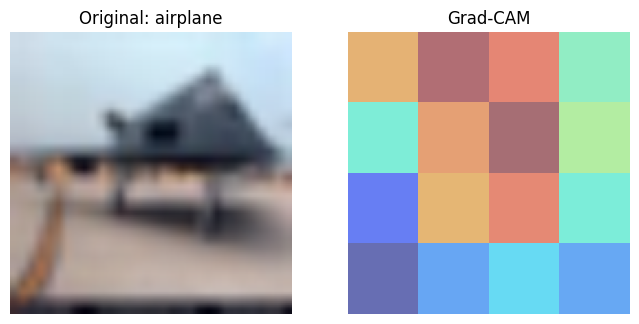

In [5]:
images, labels = next(iter(val_loader))
images = images.to(device)

gradcam = GradCAM(model, model.layer4)
heatmap = gradcam.generate(images)

img = images[0].permute(1, 2, 0).cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Original: {class_names[labels.item()]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.title("Grad-CAM")
plt.axis("off")

plt.show()
